In [43]:
"""DATA 522: Practical Deep Learning Systems - Homework 1"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load experiment data
df = pd.read_csv("ExerciseData.csv")
# Keep only rows with a valid overpotential (required for labels in 1.2–1.6)
df = df.dropna(subset=["Overpotential V at 50.0 mA/cm2"])

In [44]:
df.head()
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 454 entries, 0 to 498
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Experiment                      454 non-null    object 
 1   V                               454 non-null    int64  
 2   Cr                              454 non-null    int64  
 3   Mg                              454 non-null    int64  
 4   Fe                              454 non-null    int64  
 5   Co                              454 non-null    int64  
 6   Ni                              454 non-null    int64  
 7   Cu                              454 non-null    int64  
 8   S                               454 non-null    int64  
 9   Se                              454 non-null    int64  
 10  P                               454 non-null    int64  
 11  Voltage                         454 non-null    float64
 12  Time                            454 non-n

,V,Cr,Mg,Fe,Co,Ni,Cu,S,Se,P,Voltage,Time,Overpotential V at 50.0 mA/cm2
count,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000
mean,5.253304,4.883260,4.746696,5.277533,5.233480,5.149780,5.451542,9.303965,8.962555,8.638767,-1.292511,105.859031,-0.643143
std,6.688904,6.369563,6.324184,6.663967,6.643766,6.920522,6.846541,8.665739,8.811788,8.977868,0.147642,36.947997,0.160628
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.500000,60.000000,-1.004700
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.400000,60.000000,-0.765450
50%,5.000000,5.000000,4.500000,5.000000,5.000000,4.000000,5.000000,7.000000,5.000000,5.000000,-1.300000,90.000000,-0.672200
75%,8.000000,5.000000,8.000000,10.000000,8.000000,10.000000,10.000000,15.000000,15.000000,15.000000,-1.200000,150.000000,-0.527200
max,30.000000,35.000000,35.000000,35.000000,35.000000,50.000000,45.000000,45.000000,40.000000,50.000000,-1.000000,180.000000,-0.242700


Step 1.1 - Visualizing η in the 11-dimensional space
=======
The 11 dimensions cannot be plotted directly, so I reduced the feature space to 2 dimensions using PCA. The scatter plot shows each experiment in the space of the first two principal components; points are colored by |η| (smaller |η| = better catalyst). This gives a single 2D view of how overpotential is distributed in the 11D input space.

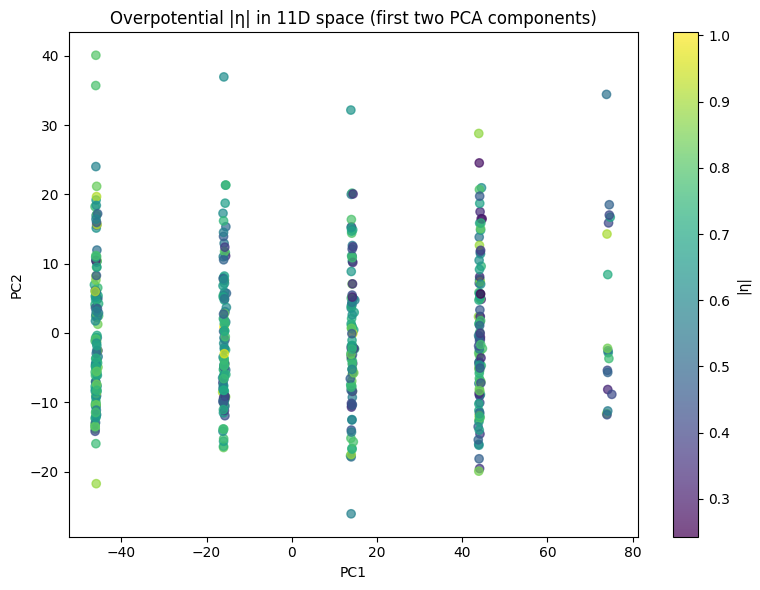

In [45]:
# The 11 input variables: element concentrations + Voltage, Time
feature_cols = ["V", "Cr", "Mg", "Fe", "Co", "Ni", "Cu", "S", "Se", "P", "Voltage", "Time"]

X = df[feature_cols]
eta = df["Overpotential V at 50.0 mA/cm2"]
eta_abs = eta.abs()

from sklearn.decomposition import PCA

# Reduce 11D to 2D for plotting; random_state for reproducibility
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X)

# Scatter: each point is an experiment; color = |η| (smaller = better catalyst)
plt.figure(figsize=(8, 6))
sc = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=eta_abs, cmap="viridis", alpha=0.7)
plt.colorbar(sc, label="|η|")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Overpotential |η| in 11D space (first two PCA components)")
plt.tight_layout()
plt.show()

Step 1.2 - Train / validation / test split
========
I define the binary target y: good catalyst = 1 if |η| < 0.6, bad = 0 otherwise. The data is then split randomly (with a fixed seed for reproducibility) into 70% training, 15% validation, and 15% test. The same splits are used for training and evaluating models in 1.4 - 1.6.


In [46]:
# Good catalyst: |η| < 0.6 → 1; bad: |η| ≥ 0.6 → 0
y = (eta_abs < 0.6).astype(int)

from sklearn.model_selection import train_test_split

# First split: 70% train, 30% temporary (will become val + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
# Second split: split the 30% into 15% val, 15% test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train:", X_train.shape[0], "\nVal:", X_val.shape[0], "\nTest:", X_test.shape[0])

Train: 317 
Val: 68 
Test: 69


Step 1.3 - Good vs bad catalyst percentages
========
On the cleaned dataset, I count how many points are "good" (|η| < 0.6) and “bad” (|η| ≥ 0.6) and report their percentages. This summarizes class balance before modeling.

In [47]:
# Count and percentage of good (1) vs bad (0) in the full dataset
n_total = len(y)
n_good = (y == 1).sum()
n_bad = (y == 0).sum()

pct_good = n_good / n_total * 100
pct_bad = n_bad / n_total * 100

print(f"Good catalysts (|η| < 0.6): {n_good} ({pct_good:.2f}%)")
print(f"Bad catalysts (|η| ≥ 0.6):  {n_bad} ({pct_bad:.2f}%)")

Good catalysts (|η| < 0.6): 165 (36.34%)
Bad catalysts (|η| ≥ 0.6):  289 (63.66%)


Step 1.4 - Default Random Forest and metrics
========
I train a Random Forest classifier with default hyperparameters on the training set only. I then predict on the training, validation, and test sets and compute **precision**, **recall**, and **F1** for each. This gives a baseline and shows how the model performs on unseen data (val and test).

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score

# Default hyperparameters; random_state for reproducibility
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predict on all three sets
y_train_pred = rf.predict(X_train)
y_val_pred = rf.predict(X_val)
y_test_pred = rf.predict(X_test)

# Precision, recall, F1 for training set
prec_train = precision_score(y_train, y_train_pred, zero_division=0)
rec_train = recall_score(y_train, y_train_pred, zero_division=0)
f1_train = f1_score(y_train, y_train_pred, zero_division=0)

# Precision, recall, F1 for validation set
prec_val = precision_score(y_val, y_val_pred, zero_division=0)
rec_val = recall_score(y_val, y_val_pred, zero_division=0)
f1_val = f1_score(y_val, y_val_pred, zero_division=0)

# Precision, recall, F1 for test set
prec_test = precision_score(y_test, y_test_pred, zero_division=0)
rec_test = recall_score(y_test, y_test_pred, zero_division=0)
f1_test = f1_score(y_test, y_test_pred, zero_division=0)

# Summary table
results_1_4 = pd.DataFrame({
    "Precision": [prec_train, prec_val, prec_test],
    "Recall":    [rec_train, rec_val, rec_test],
    "F1":        [f1_train, f1_val, f1_test]
}, index=["Training", "Validation", "Test"])
print(results_1_4)

            Precision    Recall        F1
Training         1.00  1.000000  1.000000
Validation       0.72  0.600000  0.654545
Test             0.72  0.818182  0.765957


Step 1.5 - Hyperparameter tuning
========
I try four different hyperparameter combinations for the Random Forest (e.g. `n_estimators`, `max_depth`, `min_samples_split`). For each combination I train on the training set and record precision, recall, and F1 on the training, validation, and test sets, plus their averages. The table lets us compare how different settings affect performance and overfitting.

In [49]:
# Four different hyperparameter combinations to compare
param_combos = [
    {"n_estimators": 100, "max_depth": None, "min_samples_split": 2},
    {"n_estimators": 50,  "max_depth": 10,   "min_samples_split": 2},
    {"n_estimators": 200, "max_depth": 20,   "min_samples_split": 5},
    {"n_estimators": 100, "max_depth": 5,    "min_samples_split": 10},
]

results_1_5 = []

for i, params in enumerate(param_combos):
    # Train one RF per combination
    rf = RandomForestClassifier(random_state=42, **params)
    rf.fit(X_train, y_train)

    pred_train = rf.predict(X_train)
    pred_val = rf.predict(X_val)
    pred_test = rf.predict(X_test)

    # Record hyperparameters and metrics on train, val, test
    row = {
        "combo": i + 1,
        **params,
        "prec_train": precision_score(y_train, pred_train, zero_division=0),
        "rec_train": recall_score(y_train, pred_train, zero_division=0),
        "f1_train": f1_score(y_train, pred_train, zero_division=0),
        "prec_val": precision_score(y_val, pred_val, zero_division=0),
        "rec_val": recall_score(y_val, pred_val, zero_division=0),
        "f1_val": f1_score(y_val, pred_val, zero_division=0),
        "prec_test": precision_score(y_test, pred_test, zero_division=0),
        "rec_test": recall_score(y_test, pred_test, zero_division=0),
        "f1_test": f1_score(y_test, pred_test, zero_division=0),
    }
    # Average of each metric across the three sets
    row["prec_avg"] = (row["prec_train"] + row["prec_val"] + row["prec_test"]) / 3
    row["rec_avg"] = (row["rec_train"] + row["rec_val"] + row["rec_test"]) / 3
    row["f1_avg"] = (row["f1_train"] + row["f1_val"] + row["f1_test"]) / 3
    results_1_5.append(row)

df_1_5 = pd.DataFrame(results_1_5)
print(df_1_5)

   combo  n_estimators  max_depth  min_samples_split  prec_train  rec_train  \
0      1           100        NaN                  2    1.000000   1.000000   
1      2            50       10.0                  2    1.000000   1.000000   
2      3           200       20.0                  5    1.000000   0.982301   
3      4           100        5.0                 10    0.923913   0.752212   

   f1_train  prec_val   rec_val    f1_val  prec_test  rec_test   f1_test  \
0  1.000000  0.720000  0.600000  0.654545   0.720000  0.818182  0.765957   
1  1.000000  0.680000  0.566667  0.618182   0.720000  0.818182  0.765957   
2  0.991071  0.666667  0.533333  0.592593   0.703704  0.863636  0.775510   
3  0.829268  0.736842  0.466667  0.571429   0.750000  0.818182  0.782609   

   prec_avg   rec_avg    f1_avg  
0  0.813333  0.806061  0.806834  
1  0.800000  0.794949  0.794713  
2  0.790123  0.793090  0.786391  
3  0.803585  0.679020  0.727769  


Step 1.6 - Permutation feature importance (PFI)
========
I measure which input variables matter most by permutation feature importance: for each feature we shuffle its values on the validation set and see how much performance drops. I do this for two setups: **without** and **with** input normalization (StandardScaler), so I can see whether scaling changes which features look important. I report and compare the **top 5 most important variables** for each setup.

In [50]:
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler

# Model and PFI WITHOUT normalization
rf_raw = RandomForestClassifier(random_state=42)
rf_raw.fit(X_train, y_train)

# PFI: shuffle each feature on val set and measure drop in score (n_repeats for stability)
pfi_raw = permutation_importance(rf_raw, X_val, y_val, random_state=42, n_repeats=10)

df_pfi_raw = pd.DataFrame({
    "feature": feature_cols,
    "importance": pfi_raw.importances_mean,
    "std": pfi_raw.importances_std,
}).sort_values("importance", ascending=False)

# Normalize inputs (fit on train only, then transform train/val/test)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Model and PFI WITH normalization
rf_scaled = RandomForestClassifier(random_state=42)
rf_scaled.fit(X_train_scaled, y_train)

pfi_scaled = permutation_importance(rf_scaled, X_val_scaled, y_val, random_state=42, n_repeats=10)

df_pfi_scaled = pd.DataFrame({
    "feature": feature_cols,
    "importance": pfi_scaled.importances_mean,
    "std": pfi_scaled.importances_std,
}).sort_values("importance", ascending=False)

# Report top 5 features for each setup
top5_raw = df_pfi_raw.head(5)
print("Top 5 most important (no normalization):")
print(top5_raw[["feature", "importance"]])

top5_scaled = df_pfi_scaled.head(5)
print("\nTop 5 most important (with normalization):")
print(top5_scaled[["feature", "importance"]])

# Side-by-side comparison of all features
comparison = pd.DataFrame({
    "feature": feature_cols,
    "raw": pfi_raw.importances_mean,
    "normalized": pfi_scaled.importances_mean,
}).sort_values("raw", ascending=False)
print("\n", comparison)

Top 5 most important (no normalization):
  feature  importance
8      Se    0.113235
5      Ni    0.058824
0       V    0.057353
4      Co    0.054412
2      Mg    0.032353

Top 5 most important (with normalization):
  feature  importance
8      Se    0.091176
0       V    0.058824
4      Co    0.041176
5      Ni    0.041176
2      Mg    0.019118

     feature       raw  normalized
8        Se  0.113235    0.091176
5        Ni  0.058824    0.041176
0         V  0.057353    0.058824
4        Co  0.054412    0.041176
2        Mg  0.032353    0.019118
10  Voltage  0.010294    0.007353
7         S  0.005882    0.007353
6        Cu -0.010294   -0.014706
9         P -0.013235   -0.032353
11     Time -0.013235   -0.036765
1        Cr -0.020588   -0.035294
3        Fe -0.054412   -0.060294


**Without** normalization, the top 5 most important variables are: Se, Ni, V, Co, Mg  
**With** normalization, the top 5 most important variables are: Se, V, Co, Ni, Mg